In [1]:
import numpy as np 
import pandas as pd 
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score
#from sklearn.cross_validation import KFold, train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
import math

%config InlineBackend.figure_format = 'png' 

In [2]:
nba_shots = pd.read_csv('shot_logs.csv')

In [3]:
nba_shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [4]:
nba_shots.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [5]:
#Cleaning Data

#only want positive touch_time --> clokc running out 
nba_shots = nba_shots[nba_shots['TOUCH_TIME'] >=0]

#only want medium shot distances --> last second throw
nba_shots = nba_shots[nba_shots['SHOT_DIST'] <40]

#remove shot clock NAN --> violation results in turnover
nan = float('nan')
nba_shots = nba_shots[~np.isnan(nba_shots['SHOT_CLOCK'])]

#remove FGM NAN --> no value for missed field goals
nan = float('nan')
nba_shots = nba_shots[~np.isnan(nba_shots['FGM'])]

#Close def dist
nba_shots = nba_shots[nba_shots['CLOSE_DEF_DIST']<30]

In [6]:
#Target Dataset

target_dataset = nba_shots['FGM']

In [7]:
target_dataset_extra = nba_shots[['SHOT_DIST', 'TOUCH_TIME' , 'TOUCH_TIME' , 'FINAL_MARGIN' , 'PERIOD' , 'SHOT_CLOCK' , 'DRIBBLES' , 
                           'CLOSE_DEF_DIST' , 'PTS']]

In [8]:
print(nba_shots['FGM'].shape)
print(target_dataset.shape)
print(target_dataset_extra.shape)

(122152,)
(122152,)
(122152, 9)


In [22]:
#Looking for Most Predictive Features

model = XGBClassifier()
model.fit(target_dataset_extra, target_dataset)

#plot feature importance
plot_importance(model)
pyplot.show()

ValueError: feature_names must be unique

As expected, points are heavily correlated with FGM 

In [9]:
#Remove FGM

target_dataset_extra = nba_shots[['SHOT_DIST', 'TOUCH_TIME', 'FINAL_MARGIN',
                                 'PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'CLOSE_DEF_DIST']]

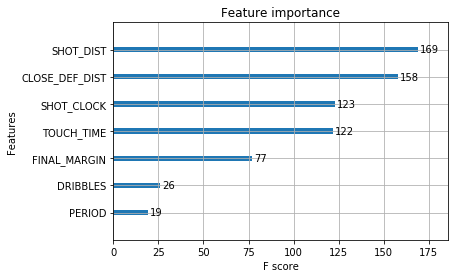

In [10]:
model = XGBClassifier()
model.fit(target_dataset_extra, target_dataset)

#plot feature importance

plot_importance(model, importance_type = 'weight')
pyplot.show()

    Correlated but not as directly related as the points or field goals missed

C:\Users\aisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


Text(0, 0.5, '%')

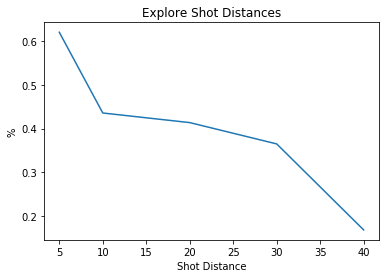

In [11]:
#Shot Distance 

distances = [0, 5, 10, 20, 30, 40, 50]

shot_made = [(nba_shots[np.logical_and(np.logical_and(nba_shots['SHOT_DIST']
                                                   >distances[i-1], nba_shots['SHOT_DIST']<distances[i] ), nba_shots['FGM']
                                                   ==1)].size/nba_shots[np.logical_and(nba_shots['SHOT_DIST']>distances[i-1], 
                                                                                      nba_shots['SHOT_DIST']<distances[i]) ].size)
             for i in range(1, len(distances))]

lambda_results = pd.Series(shot_made, index = distances[1:len(distances)])
lambda_results.plot(title = "Explore Shot Distances")
plt.xlabel("Shot Distance")
plt.ylabel("%")

SET TARGET - BE BETTER THAN MOST COMMON VALUE

In [13]:
print('shots made', np.count_nonzero(target_dataset))
print('shots missed', target_dataset.size-np.count_nonzero(target_dataset))
print('total shots', target_dataset.size)
print ('we must at least have better precision than ',(target_dataset.size-np.count_nonzero(target_dataset))/target_dataset.size)

shots made 55743
shots missed 66409
total shots 122152
we must at least have better precision than  0.5436587202829262


PREDICT WITH EVERY FEATURE

In [14]:
print("every feature")
print(target_dataset.shape)


X_train, X_test, y_train, y_test = train_test_split( target_dataset_extra[['SHOT_DIST','TOUCH_TIME','FINAL_MARGIN','PERIOD','SHOT_CLOCK','DRIBBLES','CLOSE_DEF_DIST']], target_dataset, test_size=0.50, random_state=42)
   
xgb_model = XGBClassifier().fit(X_train,y_train)

predictions = xgb_model.predict(X_test)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print(precision_score(actuals, predictions) )

every feature
(122152,)
[[28026  5290]
 [18009  9751]]
0.6482946612592247


PREDICT WITH 3 IMPORTANT FEATURES

In [15]:
print("3 most important features")

X_train, X_test, y_train, y_test = train_test_split( target_dataset_extra[['SHOT_DIST','TOUCH_TIME','SHOT_CLOCK']], target_dataset, test_size=0.50, random_state=42)
y = np.array(target_dataset)
X = target_dataset_extra[['SHOT_DIST','TOUCH_TIME','SHOT_CLOCK']].as_matrix()

   
xgb_model = XGBClassifier().fit(X_train,y_train)

predictions = xgb_model.predict(X_test)

actuals = y_test

print(confusion_matrix(actuals, predictions))
print(precision_score(actuals, predictions) )

3 most important features


C:\Users\aisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


[[27203  6113]
 [17593 10167]]
0.6245085995085995


RESULT: 
    Most common value precision: 55%
    My model: 63%

PLAYOFF VISULIZATIONS 

In [16]:
playoff_shooting = pd.read_csv("playoff_shots.csv")
playoff_shooting

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,41700131,149,2544,LeBron James,1610612739,Cleveland Cavaliers,1,1,24,...,Left Side Center(LC),24+ ft.,26,-168,206,1,0,20180415,CLE,IND
1,Shot Chart Detail,41700131,153,2544,LeBron James,1610612739,Cleveland Cavaliers,1,1,5,...,Center(C),Less Than 8 ft.,0,3,1,1,0,20180415,CLE,IND
2,Shot Chart Detail,41700131,155,2544,LeBron James,1610612739,Cleveland Cavaliers,1,0,58,...,Center(C),Less Than 8 ft.,0,0,-6,1,0,20180415,CLE,IND
3,Shot Chart Detail,41700131,187,2544,LeBron James,1610612739,Cleveland Cavaliers,2,11,8,...,Center(C),Less Than 8 ft.,1,-8,13,1,1,20180415,CLE,IND
4,Shot Chart Detail,41700131,195,2544,LeBron James,1610612739,Cleveland Cavaliers,2,10,22,...,Center(C),Less Than 8 ft.,1,2,10,1,1,20180415,CLE,IND
5,Shot Chart Detail,41700131,242,2544,LeBron James,1610612739,Cleveland Cavaliers,2,7,37,...,Left Side Center(LC),16-24 ft.,22,-109,201,1,0,20180415,CLE,IND
6,Shot Chart Detail,41700131,246,2544,LeBron James,1610612739,Cleveland Cavaliers,2,7,7,...,Center(C),Less Than 8 ft.,0,-8,5,1,1,20180415,CLE,IND
7,Shot Chart Detail,41700131,263,2544,LeBron James,1610612739,Cleveland Cavaliers,2,5,47,...,Center(C),Less Than 8 ft.,2,14,15,1,1,20180415,CLE,IND
8,Shot Chart Detail,41700131,266,2544,LeBron James,1610612739,Cleveland Cavaliers,2,5,21,...,Center(C),Less Than 8 ft.,2,-7,20,1,1,20180415,CLE,IND
9,Shot Chart Detail,41700131,287,2544,LeBron James,1610612739,Cleveland Cavaliers,2,3,57,...,Center(C),Less Than 8 ft.,2,9,27,1,0,20180415,CLE,IND


PLAYERS TO STUDY - LBJ, GEORGE HILL, STEPH CURRY, KEVIN DURANT 

In [19]:
key_players = playoff_shooting[(playoff_shooting.PLAYER_NAME == 'Stephen Curry') | # Golden State Warriors
                        (playoff_shooting.PLAYER_NAME == 'Kevin Durant') |
                        (playoff_shooting.PLAYER_NAME == 'LeBron James') | # Cleveland Cavaliers
                        (playoff_shooting.PLAYER_NAME == 'Kevin Love')]
key_players

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,41700131,149,2544,LeBron James,1610612739,Cleveland Cavaliers,1,1,24,...,Left Side Center(LC),24+ ft.,26,-168,206,1,0,20180415,CLE,IND
1,Shot Chart Detail,41700131,153,2544,LeBron James,1610612739,Cleveland Cavaliers,1,1,5,...,Center(C),Less Than 8 ft.,0,3,1,1,0,20180415,CLE,IND
2,Shot Chart Detail,41700131,155,2544,LeBron James,1610612739,Cleveland Cavaliers,1,0,58,...,Center(C),Less Than 8 ft.,0,0,-6,1,0,20180415,CLE,IND
3,Shot Chart Detail,41700131,187,2544,LeBron James,1610612739,Cleveland Cavaliers,2,11,8,...,Center(C),Less Than 8 ft.,1,-8,13,1,1,20180415,CLE,IND
4,Shot Chart Detail,41700131,195,2544,LeBron James,1610612739,Cleveland Cavaliers,2,10,22,...,Center(C),Less Than 8 ft.,1,2,10,1,1,20180415,CLE,IND
5,Shot Chart Detail,41700131,242,2544,LeBron James,1610612739,Cleveland Cavaliers,2,7,37,...,Left Side Center(LC),16-24 ft.,22,-109,201,1,0,20180415,CLE,IND
6,Shot Chart Detail,41700131,246,2544,LeBron James,1610612739,Cleveland Cavaliers,2,7,7,...,Center(C),Less Than 8 ft.,0,-8,5,1,1,20180415,CLE,IND
7,Shot Chart Detail,41700131,263,2544,LeBron James,1610612739,Cleveland Cavaliers,2,5,47,...,Center(C),Less Than 8 ft.,2,14,15,1,1,20180415,CLE,IND
8,Shot Chart Detail,41700131,266,2544,LeBron James,1610612739,Cleveland Cavaliers,2,5,21,...,Center(C),Less Than 8 ft.,2,-7,20,1,1,20180415,CLE,IND
9,Shot Chart Detail,41700131,287,2544,LeBron James,1610612739,Cleveland Cavaliers,2,3,57,...,Center(C),Less Than 8 ft.,2,9,27,1,0,20180415,CLE,IND


BUILDING THE COURT - USING PLOTLY

In [22]:
court_shapes = []

#Outer Lines
outer_lines_shape = dict(
    type='rect',
    xref='x',
    yref='y',
    x0='-250',
    y0='-47.5',
    x1='250',
    y1='422.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(outer_lines_shape)

#Hoop Shape
hoop_shape = dict(
    type='circle',
    xref='x',
    yref='y',
    x0='7.5',
    y0='7.5',
    x1='-7.5',
    y1='-7.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(hoop_shape)

#Basket Backboard
backboard_shape = dict(
    type='rect',
    xref='x',
    yref='y',
    x0='-30',
    y0='-7.5',
    x1='30',
    y1='-6.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    ),
    fillcolor='rgba(10, 10, 10, 1)'
)
 
court_shapes.append(backboard_shape)
#Outer Box of Three-Second Area
outer_three_sec_shape = dict(
    type='rect',
    xref='x',
    yref='y',
    x0='-80',
    y0='-47.5',
    x1='80',
    y1='143.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(outer_three_sec_shape)
#Inner Box of Three-Second Area
inner_three_sec_shape = dict(
    type='rect',
    xref='x',
    yref='y',
    x0='-60',
    y0='-47.5',
    x1='60',
    y1='143.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(inner_three_sec_shape)

#Three Point Line (Left)
left_line_shape = dict(
    type='line',
    xref='x',
    yref='y',
    x0='-220',
    y0='-47.5',
    x1='-220',
    y1='92.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
           )
)
 
court_shapes.append(left_line_shape)

#Three Point Line (Right)
right_line_shape = dict(
    type='line',
    xref='x',
    yref='y',
    x0='220',
    y0='-47.5',
    x1='220',
    y1='92.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(right_line_shape)
#Three Point Line Arc
three_point_arc_shape = dict(
    type='path',
    xref='x',
    yref='y',
    path='M -220 92.5 C -70 300, 70 300, 220 92.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(three_point_arc_shape)

#Center Circle
center_circle_shape = dict(
    type='circle',
    xref='x',
    yref='y',
    x0='60',
    y0='482.5',
    x1='-60',
    y1='362.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
court_shapes.append(center_circle_shape)

#Restraining Circle
res_circle_shape = dict(
    type='circle',
    xref='x',
    yref='y',
    x0='20',
    y0='442.5',
    x1='-20',
    y1='402.5',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(res_circle_shape)

#Free Throw Circle
free_throw_circle_shape = dict(
    type='circle',
    xref='x',
    yref='y',
    x0='60',
    y0='200',
    x1='-60',
    y1='80',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
court_shapes.append(free_throw_circle_shape)

#Restricted Area
res_area_shape = dict(
    type='circle',
    xref='x',
    yref='y',
    x0='40',
    y0='40',
    x1='-40',
    y1='-40',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1,
        dash='dot'
    )
)
 
court_shapes.append(res_area_shape)

PLOTTING THE SHOTS

In [31]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

def updateVisibility(selectedPlayer):
    visibilityValues = []
    for player in list(key_players.PLAYER_NAME.unique()):
        if player == selectedPlayer:
            visibilityValues.append(True)
            visibilityValues.append(True)
        else:
            visibilityValues.append(False)
            visibilityValues.append(False)
    return visibilityValues

data = []
buttons_data = []
for player in list(key_players.PLAYER_NAME.unique()):
    shot_trace_made = go.Scatter(
        x = key_players[(key_players['EVENT_TYPE'] == 'Made Shot') & (key_players['PLAYER_NAME'] == player)]['LOC_X'],
        y = key_players[(key_players['EVENT_TYPE'] == 'Made Shot') & (key_players['PLAYER_NAME'] == player)]['LOC_Y'],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'rgba(63, 191, 63, 0.9)',
        ), 
        name = 'Made',
        text = key_players[(key_players['EVENT_TYPE'] == 'Made Shot') & (key_players['PLAYER_NAME'] == player)]['SHOT_ZONE_BASIC'],
        textposition = 'top right',
        textfont = dict(
            color = 'rgba(75, 85, 102,0.7)'
        ),
        visible = (player =='LeBron James')
    )

    shot_trace_missed = go.Scatter(
        x = key_players[(key_players['EVENT_TYPE'] == 'Missed Shot') & (key_players['PLAYER_NAME'] == player)]['LOC_X'],
        y = key_players[(key_players['EVENT_TYPE'] == 'Missed Shot') & (key_players['PLAYER_NAME'] == player)]['LOC_Y'],
        mode = 'markers',
        marker = dict(
            size = 6,
            color = 'rgba(241, 18, 18, 0.9)',
        ), 
        name = 'Missed',
        text = key_players[(key_players['EVENT_TYPE'] == 'Missed Shot') & (key_players['PLAYER_NAME'] == player)]['SHOT_ZONE_BASIC'],
        textposition = 'top right',
        textfont = dict(
            color = 'rgba(75, 85, 102,0.7)'
              ),
        visible = (player =='LeBron James')
    )

    data.append(shot_trace_made)
    data.append(shot_trace_missed)
    
    buttons_data.append(
        dict(
            label = player,
            method = 'update',
            args = [{'visible': updateVisibility(player)}]
        )
    )
    

updatemenus = list([
    dict(active=0,
         buttons = buttons_data,
         direction = 'down',
         pad = {'r': 10, 't': 10},
         showactive = True,
         x = 0.21,
         xanchor = 'left',
          y = 1.19,
         yanchor = 'top',
         font = dict (
             size = 14
         )
    )
])

layout = go.Layout(
    title='________________ Shot Chart',
    titlefont=dict(
        size=14
    ),
    hovermode = 'closest',
    updatemenus = updatemenus,
    showlegend = True,
    height = 600,
    width = 600, 
    shapes = court_shapes,
    xaxis = dict(
        showticklabels = False
    ),
    yaxis = dict(
        showticklabels = False
    )
)
 
fig = go.Figure(data=data, layout=layout)
iplot(fig)

ADDING SHOT ZONES 

In [32]:
playoff_shooting.SHOT_ZONE_AREA.unique()

array(['Left Side Center(LC)', 'Center(C)', 'Left Side(L)',
       'Right Side Center(RC)', 'Right Side(R)', 'Back Court(BC)'],
      dtype=object)

In [33]:
playoff_shooting.SHOT_ZONE_BASIC.unique()

array(['Above the Break 3', 'Restricted Area', 'Mid-Range',
       'In The Paint (Non-RA)', 'Left Corner 3', 'Right Corner 3',
       'Backcourt'], dtype=object)

In [35]:
zone_shapes = []

#Three Point Line Arc Top Left
zone1 = dict(
    type='path',
    xref='x',
    yref='y',
    path='M -250,92 L -220,92 C -187,140 -161,174 -80,228  L -95,350 L -250,350 Z',
    fillcolor= 'rgba(93, 140, 255, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
zone_shapes.append(zone1)
#Three Point Line Arc Top Right
zone2 = dict(
    type='path',
    xref='x',
    yref='y',
    path='M 250,92 L 220,92 C 187,140 161,174 80,228  L 95,350 L 250,350 Z',
    fillcolor= 'rgba(93, 255, 18, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
 
zone_shapes.append(zone2)

#Three Point Line Arc Top Center
zone3 = dict(
    type='path',
    xref='x',
    yref='y',
    path='M -80,228 C -50,240 0,266 80,228 L 95,350 L -95,350 Z',
    fillcolor= 'rgba(253, 153, 18, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
zone_shapes.append(zone3)

#Three Point Line Left Corner
zone4 = dict(
    type='path',
    xref='x',
    yref='y',
    path='M -250,-47.5 L -220,-47.5 L -220,92 L -250,92 Z',
    fillcolor= 'rgba(253, 153, 18, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)

zone_shapes.append(zone4)

#Three Point Line Right Corner
zone5 = dict(
    type='path',
    xref='x',
    yref='y',
    path='M 250,-47.5 L 220,-47.5 L 220,92 L 250,92 Z',
    fillcolor= 'rgba(253, 153, 18, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
        )
)

zone_shapes.append(zone5)

#Under the basket
zone6 = dict(
    type='path',
    xref='x',
    yref='y',
    path='M -40,-47.5 L -40,0 C -40,53 40,53 40,0 L 40,-47.5 Z',
    fillcolor= 'rgba(253, 153, 18, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
zone_shapes.append(zone6)

#Paint
zone7 = dict(    
    type='path',
    xref='x',
    yref='y',
    path='M -60,-47.5 L -40,-47.5 L -40,0 C -40,53 40,53 40,0 L 40,-47.5 L 60,-47.5 L 60,143.5 L -60,143.5 Z',
    fillcolor= 'rgba(253, 20, 18, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)

zone_shapes.append(zone7)
#Midrange Center
zone8 = dict(    
    type='path',
    xref='x',
    yref='y',
    path='M -60,143.5 L -80,228 C -50,240 0,266 80,228 L 60,143.5 Z',
    fillcolor= 'rgba(54, 239, 233, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)

zone_shapes.append(zone8)

#Midrange Center Left
zone8 = dict(    
    type='path',
    xref='x',
    yref='y',
    path='M -220,92 C -187,140 -161,174 -80,228 L -60,143.5 L -60,92 Z',
    fillcolor= 'rgba(54, 123, 43, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
    )

zone_shapes.append(zone8)

#Midrange Center Right
zone9 = dict(    
    type='path',
    xref='x',
    yref='y',
    path='M 220,92 C 187,140 161,174 80,228 L 60,143.5 L 60,92 Z',
    fillcolor= 'rgba(54, 123, 43, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)

zone_shapes.append(zone9)
#Midrange Left
zone10 = dict(    
    type='path',
    xref='x',
    yref='y',
    path='M -220,-47.5 L -220,92 L -60,92 L -60,-47.5 Z',
    fillcolor= 'rgba(134, 23, 43, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)

zone_shapes.append(zone10)

#Midrange Right
zone11 = dict(    
    type='path',
    xref='x',
    yref='y',
    path='M 220,-47.5 L 220,92 L 60,92 L 60,-47.5 Z',
    fillcolor= 'rgba(134, 23, 43, 0.5)',
    line=dict(
        color='rgba(10, 10, 10, 1)',
        width=1
    )
)
zone_shapes.append(zone11)


shot_zones_text = go.Scatter(
    x=[-175, 0, 175, -120, 0, 120, -210, -135, 0, 0, 135, 210],
    y=[250, 300, 250, 140, 200, 140, -25, 40, 90, -10, 40, -25],
    mode='text',
    name='Zones',
    text=['<b>Zone '+str(n)+'</b>' for n in range(1,13)],
    hovertext = ['left_center_3', 'center_3', 'right_center_3', 'left_center_mid',
                 'center_mid', 'right_center_mid', 'left_corner_3', 'left_mid', 
                 'paint', 'restricted_area', 'right_mid', 'right_corner_3'],
    textposition='top right',        
    textfont = dict(
        color = 'rgba(10, 10, 10, 1)',
        size = 14
    )
)
layout = go.Layout(
    title='Shot Chart Zones',
    titlefont=dict(
        size=20
    ),
    hovermode = 'closest',
    showlegend = True,
    height = 600,
    width = 600, 
    shapes = court_shapes+zone_shapes,
    xaxis = dict(
        showticklabels = False,
        range = [-250, 250]
    ),
    yaxis = dict(
        showticklabels = False,
        range = [-47.5, 452.5]
    )
)
 
fig = go.Figure(data=[shot_zones_text], layout=layout)
iplot(fig)

FG% FOR THE ZONES 

In [38]:
league_averages = {}

#Center Three Pointer
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Center(C)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Above the Break 3')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Center(C)') 
                             & (playoff_shooting.SHOT_ZONE_BASIC == 'Above the Break 3')]['SHOT_MADE_FLAG'])
league_averages['center_3'] = made/attempted

#Left Center Three Pointer
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Left Side Center(LC)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Above the Break 3')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Left Side Center(LC)') 
                             & (playoff_shooting.SHOT_ZONE_BASIC == 'Above the Break 3')]['SHOT_MADE_FLAG'])
league_averages['left_center_3'] = made/attempted

#Right Center Three Pointer
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Right Side Center(RC)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Above the Break 3')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Right Side Center(RC)') 
                             & (playoff_shooting.SHOT_ZONE_BASIC == 'Above the Break 3')]['SHOT_MADE_FLAG'])
league_averages['right_center_3'] = made/attempted
#Left Corner Three Pointer
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_BASIC == 'Left Corner 3')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_BASIC == 'Left Corner 3')]['SHOT_MADE_FLAG'])
league_averages['left_corner_3'] = made/attempted

#Right Corner Three Pointer
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_BASIC == 'Right Corner 3')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_BASIC == 'Right Corner 3')]['SHOT_MADE_FLAG'])
league_averages['right_corner_3'] = made/attempted

#Center Mid Range
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Center(C)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Center(C)') 
                             & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')]['SHOT_MADE_FLAG'])
league_averages['center_mid'] = made/attempted

#Left Center Mid Range
made = sum(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Left Side Center(LC)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Left Side(L)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Left Side Center(LC)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Left Side(L)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
league_averages['left_center_mid'] = made/attempted

#Right Center Mid Range
made = sum(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Right Side Center(RC)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Right Side(R)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Right Side Center(RC)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Right Side(R)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
league_averages['right_center_mid'] = made/attempted

#Left Mid Range
made = sum(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Left Side(L)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Left Side(L)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Left Side(L)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Left Side(L)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
league_averages['left_mid'] = made/attempted

#Right Mid Range
made = sum(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Right Side(R)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Right Side(R)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[((playoff_shooting.SHOT_ZONE_AREA == 'Right Side(R)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'Mid-Range')) |
                        ((playoff_shooting.SHOT_ZONE_AREA == 'Right Side(R)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'))]['SHOT_MADE_FLAG'])
league_averages['right_mid'] = made/attempted

#Paint (Not Restricted Area)
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Center(C)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_AREA == 'Center(C)') 
                        & (playoff_shooting.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)')]['SHOT_MADE_FLAG'])
league_averages['paint'] = made/attempted

#Restricted Area
made = sum(playoff_shooting[(playoff_shooting.SHOT_ZONE_BASIC == 'Restricted Area')]['SHOT_MADE_FLAG'])
attempted = len(playoff_shooting[(playoff_shooting.SHOT_ZONE_BASIC == 'Restricted Area')]['SHOT_MADE_FLAG'])
league_averages['restricted_area'] = made/attempted

print('League Average FG% by Zone')
for zone, avg_made in league_averages.items():
    print('{}: {}%'.format(zone, round(avg_made*100, 2)))

League Average FG% by Zone
center_3: 32.82%
left_center_3: 33.41%
right_center_3: 34.76%
left_corner_3: 40.51%
right_corner_3: 42.15%
center_mid: 42.63%
left_center_mid: 36.74%
right_center_mid: 41.13%
left_mid: 35.82%
right_mid: 40.96%
paint: 38.37%
restricted_area: 63.92%


FG% IN EACH ZONE